In [206]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
%matplotlib inline

# One word about methodology

In order to give an accuracy of a model on a given dataset we proceed by **cross validation** on the entire dataset: we compute the loss on 40% of the dataset selected randomly several times. We do not proceed by selecting train and test data beforehand.

# Part One: Different Models on Dummy Datasets

# KNN
## 1) Implementation

In [254]:
# L2 norm KNN implem
class myKNN:
    
    def __init__(self, k):
        self._k = k
        self._data = np.empty((0,))
        return
    
    # data must be a np matrix
    # Of shape n_examples * (n_features+1)
    # With:
    #      -data[i][:-1] = features
    #      -data[i][-1] = label
    def learn(self, data, p=True):
        self._data = np.copy(data)
        if p:
            print("Done")
        
    # computes k-NN majority
    # for one query vector
    # and L2 norm
    def predict_one(self, query_vec):
        distances = np.linalg.norm(self._data[:,:-1]-query_vec,axis=1)
        kNNs = distances.argsort()[:self._k]
        number_ones = (self._data[:,-1:].squeeze())[kNNs].sum()
        # We resolve ties [0,0,1,1] by saying 1 wins (>=)
        return float(number_ones >= float(self._k)/2.0)
        
    # to_predict must be a np matrix
    # Of shape n_examples * n_features
    # Whith one feature vec by example
    def predict(self, to_predict):
        result = []
        for query in to_predict:
            result.append(self.predict_one(query))
        return np.array(result)
    
    # for plotting purpose
    def name(self):
        return "KNN with k="+str(self._k)
    
    # for cross val purpose
    # sample is a matrix of labeled examples
    def get_score_on(self, sample):
        prediction = self.predict(sample[:,:-1])
        labels = sample[:,-1:].squeeze()
        error_vec = np.abs(labels-prediction)
        return 1 - error_vec.sum()/len(sample)

## 2) Tests
### a) Moon dataset
We show the decision boundaries for different k's with **cross-valid** score in the down right corner.

In [216]:
# Dataset gen
X, y = make_moons(noise = 0.1, random_state=1)

In [275]:
# Training KNN for different k
# And computing cross-valid scores
KNN_clf = [(myKNN(k),0.0) for k in range(1,101,9)]
for (i,(model,_)) in enumerate(KNN_clf):
    score = cross_valid_score(model,np.c_[X,y])
    model.learn(np.c_[X,y],p=False)
    KNN_clf[i] =(model, score)

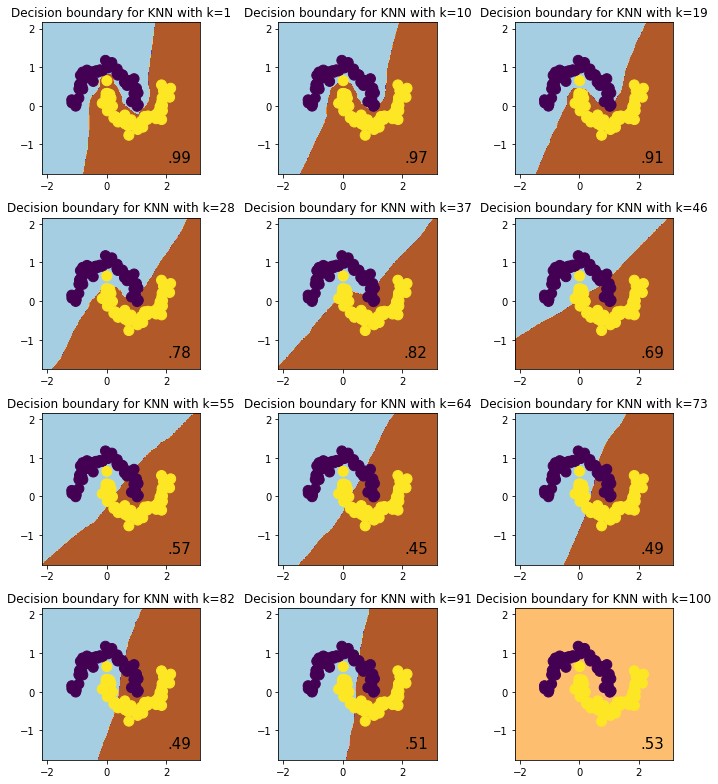

In [276]:
# Showing the results (with cross valid score in down left)
plt.figure(figsize=(10,11))
for (i,(model,score)) in enumerate(KNN_clf):
    ax = plt.subplot(len(KNN_clf)/3, 3, i+1)
    plot_frontiere(model, X, y, ax, score)
plt.tight_layout()
plt.show()

### Commentaries   
-We see that with k increasing we underfit    
-But as we use **cross validation**, the 99% for k=1 **is not** a sign of over fitting, it is just a very good model for that dataset

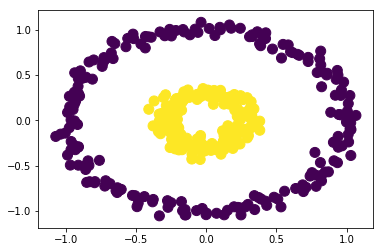

# Annexes
## Routine de plot

In [241]:
def plot_frontiere(model, X, y, ax, extra=None):
    h = .02 # grid step
    x_min= X[:, 0].min() - 1
    x_max= X[:, 0].max() + 1
    y_min = X[:, 1].min() - 1
    y_max = X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z2d = model.predict(np.c_[xx.ravel(),yy.ravel()])
    Z2d=Z2d.reshape(xx.shape)
    ax.set_title("Decision boundary for "+model.name())
    ax.contourf(xx,yy,Z2d, cmap=plt.cm.Paired)
    ax.scatter(X[:,0],X[:,1], c = y, s = 100)
    if extra != None:
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % extra).lstrip('0'), size=15, horizontalalignment='right')
    return

# Routine de cross validation

In [274]:
# Gives back a partion train/test
# with 40% test
def get_train_test(nb_examples):
    test = np.random.choice(nb_examples, int(nb_examples*0.4), replace=False)
    the_whole = set(range(0,nb_examples))
    train = list(the_whole-set(test))
    return train,test

# Computes the cross valid score
# of a model
def cross_valid_score(model, data, repeat=10):
    nb_examples = len(data)
    
    mean_score = 0.0
    for i in range(repeat):
        train_sample, test_sample = get_train_test(nb_examples)
        model.learn(data[train_sample,:],False)
        mean_score += model.get_score_on(data[test_sample,:])
    mean_score /= repeat
    
    return mean_score